# Training a ride duration prediction model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
import pickle

In [2]:
def one_hot_encoding(df, categories, enc=None):
	df_categorical = df[categories].reset_index(drop=True)
	X_numerical = df.drop(categories, axis=1).reset_index(drop=True)

	if not enc:
		enc = OneHotEncoder(dtype=np.int32, handle_unknown='ignore')
		enc.fit(df_categorical)

	X_categorical = pd.DataFrame(
		data=enc.transform(df_categorical).toarray(),
		columns=enc.get_feature_names_out()
	)

	X = pd.concat([X_numerical, X_categorical], axis=1)

	return X, enc

In [3]:
def preprocessing(url, categorical, numerical, enc=None):
	# read in the raw data
	df = pd.read_parquet(url)
	df[categorical] = df[categorical].astype(str)

    # compute duration of a trip in minutes and minutes
	df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime) / pd.Timedelta(minutes=1)
	df = df.loc[(df.duration >= 1) & (df.duration <= 60)]

	df['PU_DO'] = df.PULocationID.str.cat(df.DOLocationID, sep='_')
	categorical = ['PU_DO']

	df = df[categorical + numerical + ['duration']]
	X, enc = one_hot_encoding(df, categorical, enc=enc)

	y = X.duration
	X.drop('duration', axis=1, inplace=True)

	return X.values, y.values, enc

In [4]:
url_train = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"
url_val = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet"

In [5]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [6]:
X_train, y_train, enc = preprocessing(
	url=url_train, categorical=categorical, numerical=numerical, enc=None)
X_val, y_val, _ = preprocessing(
	url=url_val, categorical=categorical, numerical=numerical, enc=enc)

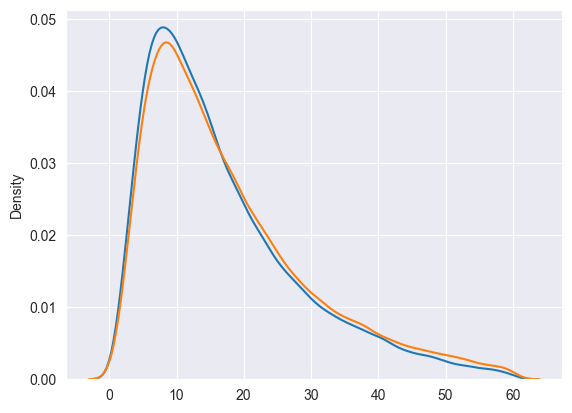

In [7]:
sns.kdeplot(x=y_train)
sns.kdeplot(x=y_val)
plt.show()

In [8]:
def train_and_evaluate(X_train, y_train, X_val, y_val, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    print(f"Validation RMSE: {rmse:.2f}")

    sns.kdeplot(x=y_pred, legend=True, fill=True)
    sns.kdeplot(x=y_val, legend=True, fill=True)
    plt.title("Distribution of taxi drip durations")
    plt.show()

Validation RMSE: 7.48


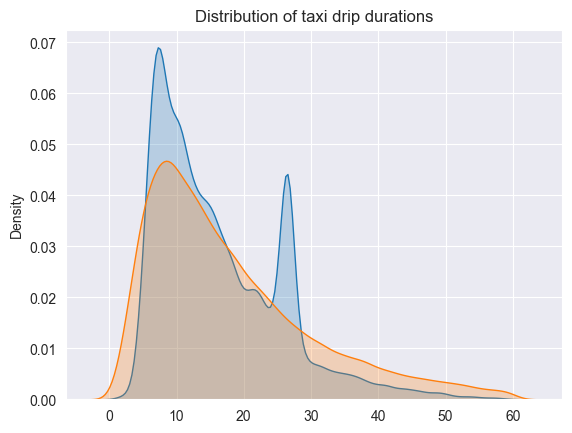

In [9]:
lr = LinearRegression()
train_and_evaluate(X_train, y_train, X_val, y_val, lr)

Validation RMSE: 9.23


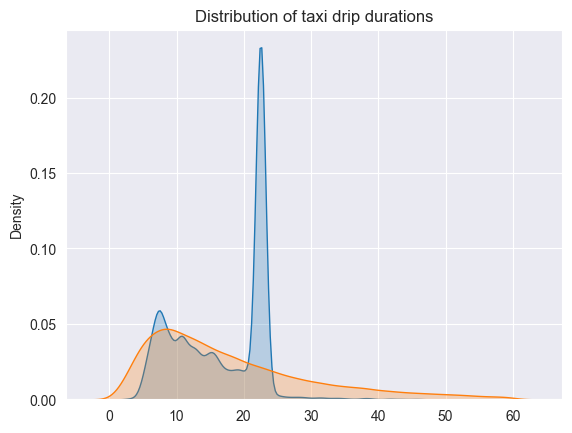

In [10]:
lasso = Lasso(alpha=.001)
train_and_evaluate(X_train, y_train, X_val, y_val, lasso)

Validation RMSE: 7.48


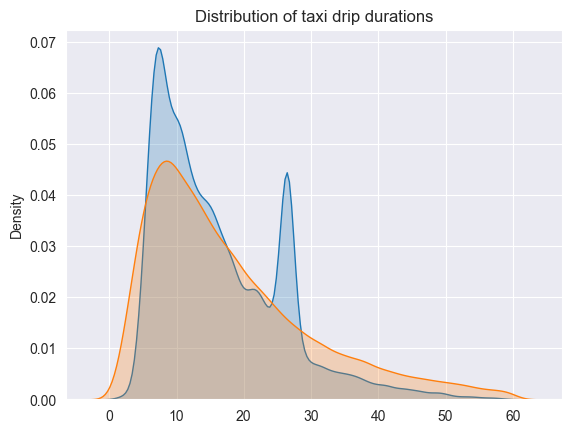

In [11]:
rr = Ridge(alpha=.01)
train_and_evaluate(X_train, y_train, X_val, y_val, rr)

In [12]:
with open('models/lin_reg,bin', 'wb') as f_out:
	pickle.dump((enc, lr), f_out)